# Classical Shadow

In [6]:
import data_acquisition_shadow
import prediction_shadow
# from prediction_shadow import estimate_exp 

from qutip import *
# from quantum_state_utils import *
from qutip.measurement import measure, measurement_statistics, measure_observable
# from Code.quantum_state_utils import generate_rand_product_density
import sys, random, math
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 400
import matplotlib.pyplot as plt

SMALL_SIZE = 10
MEDIUM_SIZE = 11  #default 10
LARGE_SIZE = 13
plt.rc('font', size=MEDIUM_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=LARGE_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=LARGE_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)  # fontsize of the tick labels

pauli_ob = {'X': sigmax(), 'Y': sigmay(), 'Z': sigmaz()}

def estimate_exp(full_measurement, one_observable):
    sum_product, cnt_match = 0, 0

    for single_measurement in full_measurement:
        not_match = 0
        product = 1

        for pauli_XYZ, position in one_observable:
            if pauli_XYZ != single_measurement[position][0]:
                not_match = 1
                break
            product *= single_measurement[position][1]
        if not_match == 1: continue

        sum_product += product
        cnt_match += 1

    return sum_product, cnt_match

def randomized_classical_shadow(num_total_measurements, system_size):
    #
    # Implementation of the randomized classical shadow
    #
    #    num_total_measurements: int for the total number of measurement rounds
    #    system_size: int for how many qubits in the quantum system
    #
    measurement_procedure = []
    for t in range(num_total_measurements):
        single_round_measurement = [random.choice(["X", "Y", "Z"]) for i in range(system_size)]
        measurement_procedure.append(single_round_measurement)
    return measurement_procedure

# ghz = ket2dm(ghz_state(3))
# pob = tensor(sigmax(),qeye(2),qeye(2))
# pob = tensor(sigmax(),sigmax(),sigmaz())
def single_copy_measurement(state,pob):
    measure_observable(state, pob)
    eigenvalues, eigenstates, probabilities = measurement_statistics(state, pob)
    # print(eigenvalues)
    # print(eigenstates)
    # print(probabilities)
    # prob_2 = [0,0]
    # for index, item in enumerate(eigenvalues):
    #     if item == 1:
    #     # if round(item) == 1:
    #         prob_2[1] += probabilities[index]
    #     # elif item == -1:
    #     elif round(item) == -1:
    #         prob_2[0] += probabilities[index]
    #     else:
    #         print('error:', item)
    # print(prob_2)
    print('probabilities of two outcomes:',(1-np.inner(eigenvalues, probabilities))/2,(1+np.inner(eigenvalues, probabilities))/2)
    # print(np.inner(eigenvalues, probabilities))
    # print('trace estimation:',expect(pob, state),'inner product',np.inner(eigenvalues, probabilities))
    return 1 if random.random() < (1+np.inner(eigenvalues, probabilities))/2 else -1
    # random.randint(0, 1)
    # s=0
    # for i in range(100000):
    #     j = 1 if random.random() < (1+np.inner(eigenvalues, probabilities))/2 else -1
    #     s+=j
    # print(s/100000)


In [82]:
state_0 = basis(2, 0)
state_1 = basis(2, 1)
state_plus = (state_0 + state_1).unit()
state_0plus = tensor(state_0, state_plus)

# state_3qubit = ket2dm(tensor([state_1,state_0,state_0]))
state_3qubit = rand_dm(N=8, dims=[[2, 2, 2], [2, 2, 2]])

Z0, Z1 = ket2dm(state_0), ket2dm(state_1)
PZ1 = [tensor(Z0, identity(2)), tensor(Z1, identity(2))]
PZ2 = [tensor(identity(2), Z0), tensor(identity(2), Z1)]

n_qubit = 3
projector_Z0 = [Z0, identity(2), identity(2)]
# projector_Z0.append(projector_Z0.pop(0))
projector_Z1 = [Z1, identity(2), identity(2)]

random_measurements = ['XXZ']

def rotate_measure(state,op):
    state_rotated = pob.dag() * state * pob
    outcomes = []
    for i in range(n_qubit):
        projector = [tensor(projector_Z0), tensor(projector_Z1)]
        collapsed_states, probabilities = measurement_statistics(state_rotated, projector)
        print(f'{i+1}-th qubit two-outcome probabilities: {probabilities}')
        outcomes.append( (op[i], 1 if random.random() < probabilities[0] else -1) )

        # print(projector_Z0)
        projector_Z0.append(projector_Z0.pop(0))
        projector_Z1.append(projector_Z1.pop(0))

    print(outcomes)
    return outcomes


for random_measurement in random_measurements:
    pob = tensor([pauli_ob[i] for i in random_measurement])
    for index, ob in enumerate(random_measurement):
        nob = [qeye(2) for i in range(n_qubit - 1)]
        nob.insert(index, pauli_ob[ob])
        # result_str += ob+' '
        # print(ob)
        outcome = single_copy_measurement(state_3qubit, tensor(nob))

        # print(collapsed_states, probabilities)
    rotate_measure(state_3qubit,random_measurement)

probabilities of two outcomes: 0.38795052074214587 0.6120494792578541
probabilities of two outcomes: 0.49612410430963655 0.5038758956903635
probabilities of two outcomes: 0.6135608873893278 0.3864391126106722
1-th qubit two-outcome probabilities: [0.487972233096482, 0.512027766903518]
2-th qubit two-outcome probabilities: [0.38643911261067226, 0.6135608873893278]
3-th qubit two-outcome probabilities: [0.560188556162564, 0.43981144383743614]
[('X', 1), ('X', -1), ('Z', 1)]


In [60]:
# print(
#     tensor([sigmaz(), sigmaz()]).dag() * ket2dm(state_0plus) *
#     tensor([sigmaz(), sigmaz()]))
# print(tensor([sigmaz(), sigmaz()]) * state_0plus)
# print(sigmay()*sigmaz())

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[0.+0.j 0.+1.j]
 [0.+1.j 0.+0.j]]


In [90]:
# randomized classical shadow consisting of 100 parallel measurements in a 20-qubit system
n_qubit = 3
shadow_size = 5000

measurement_procedure = randomized_classical_shadow(shadow_size, n_qubit)
# measurement_procedure = [a list of 100 parallel measurements, each being [a list of 20 single-qubit Pauli bases]]
# print(measurement_procedure)

# full_measurement = [a list of [list of (XYZ basis, +-1 outcome) for each qubit]]
# one_observable = [a list of (Pauli-XYZ, index for the qubit)]
# prediction_shadow.estimate_exp(full_measurement, one_observable)

state = rand_dm(N=8, dims=[[2, 2, 2], [2, 2, 2]])


full_measurement = []
for measurement in measurement_procedure:
    # print(measurement)
    # ob_outcomes = []
    # for index, ob in enumerate(measurement):
    #     nob = [qeye(2) for i in range(n_qubit - 1)]
    #     nob.insert(index, pauli_ob[ob])
    #     ob_outcomes.append( (ob, single_copy_measurement(state, tensor(nob))) )
    # print('ob_outcomes:',ob_outcomes)
    ob_outcomes = rotate_measure(state, measurement)
    full_measurement.append(ob_outcomes)
print(full_measurement)
# print(result_str)

pauli_feature_observables = ['XXZ', 'XZX', 'ZZZ', 'XXX', 'YYY']
for feature in pauli_feature_observables:
    one_observable = []
    for index, item in enumerate(feature):
        one_observable.append((item, index))
    # print(one_observable)

    sum_product, cnt_match = estimate_exp(full_measurement, one_observable)
    print(one_observable, sum_product / cnt_match,
          expect(tensor([pauli_ob[i] for i in feature]), state))


1-th qubit two-outcome probabilities: [0.43484289534276277, 0.5651571046572372]
2-th qubit two-outcome probabilities: [0.5752060803592878, 0.4247939196407122]
3-th qubit two-outcome probabilities: [0.5092146095104367, 0.49078539048956316]
[('Y', 1), ('Y', 1), ('X', -1)]
1-th qubit two-outcome probabilities: [0.43484289534276277, 0.5651571046572372]
2-th qubit two-outcome probabilities: [0.5752060803592878, 0.4247939196407122]
3-th qubit two-outcome probabilities: [0.5092146095104367, 0.49078539048956316]
[('X', 1), ('X', 1), ('Y', 1)]
1-th qubit two-outcome probabilities: [0.43484289534276277, 0.5651571046572372]
2-th qubit two-outcome probabilities: [0.5752060803592878, 0.4247939196407122]
3-th qubit two-outcome probabilities: [0.5092146095104367, 0.49078539048956316]
[('Z', 1), ('Z', -1), ('Y', -1)]
1-th qubit two-outcome probabilities: [0.43484289534276277, 0.5651571046572372]
2-th qubit two-outcome probabilities: [0.5752060803592878, 0.4247939196407122]
3-th qubit two-outcome proba

trace estimation: -0.0494, inner product: -0.0494, statistic estimation: -0.1200
trace estimation: -0.0494, inner product: -0.0494, statistic estimation: 0.0200
trace estimation: -0.0494, inner product: -0.0494, statistic estimation: -0.1800
trace estimation: -0.0494, inner product: -0.0494, statistic estimation: 0.1200
trace estimation: -0.0494, inner product: -0.0494, statistic estimation: -0.0800
trace estimation: -0.0494, inner product: -0.0494, statistic estimation: -0.0080
trace estimation: -0.0494, inner product: -0.0494, statistic estimation: -0.0400
trace estimation: -0.0494, inner product: -0.0494, statistic estimation: -0.0480
trace estimation: -0.0494, inner product: -0.0494, statistic estimation: -0.0520
trace estimation: -0.0494, inner product: -0.0494, statistic estimation: -0.0840
trace estimation: -0.0494, inner product: -0.0494, statistic estimation: -0.0760
trace estimation: -0.0494, inner product: -0.0494, statistic estimation: -0.1040
trace estimation: -0.0494, inn

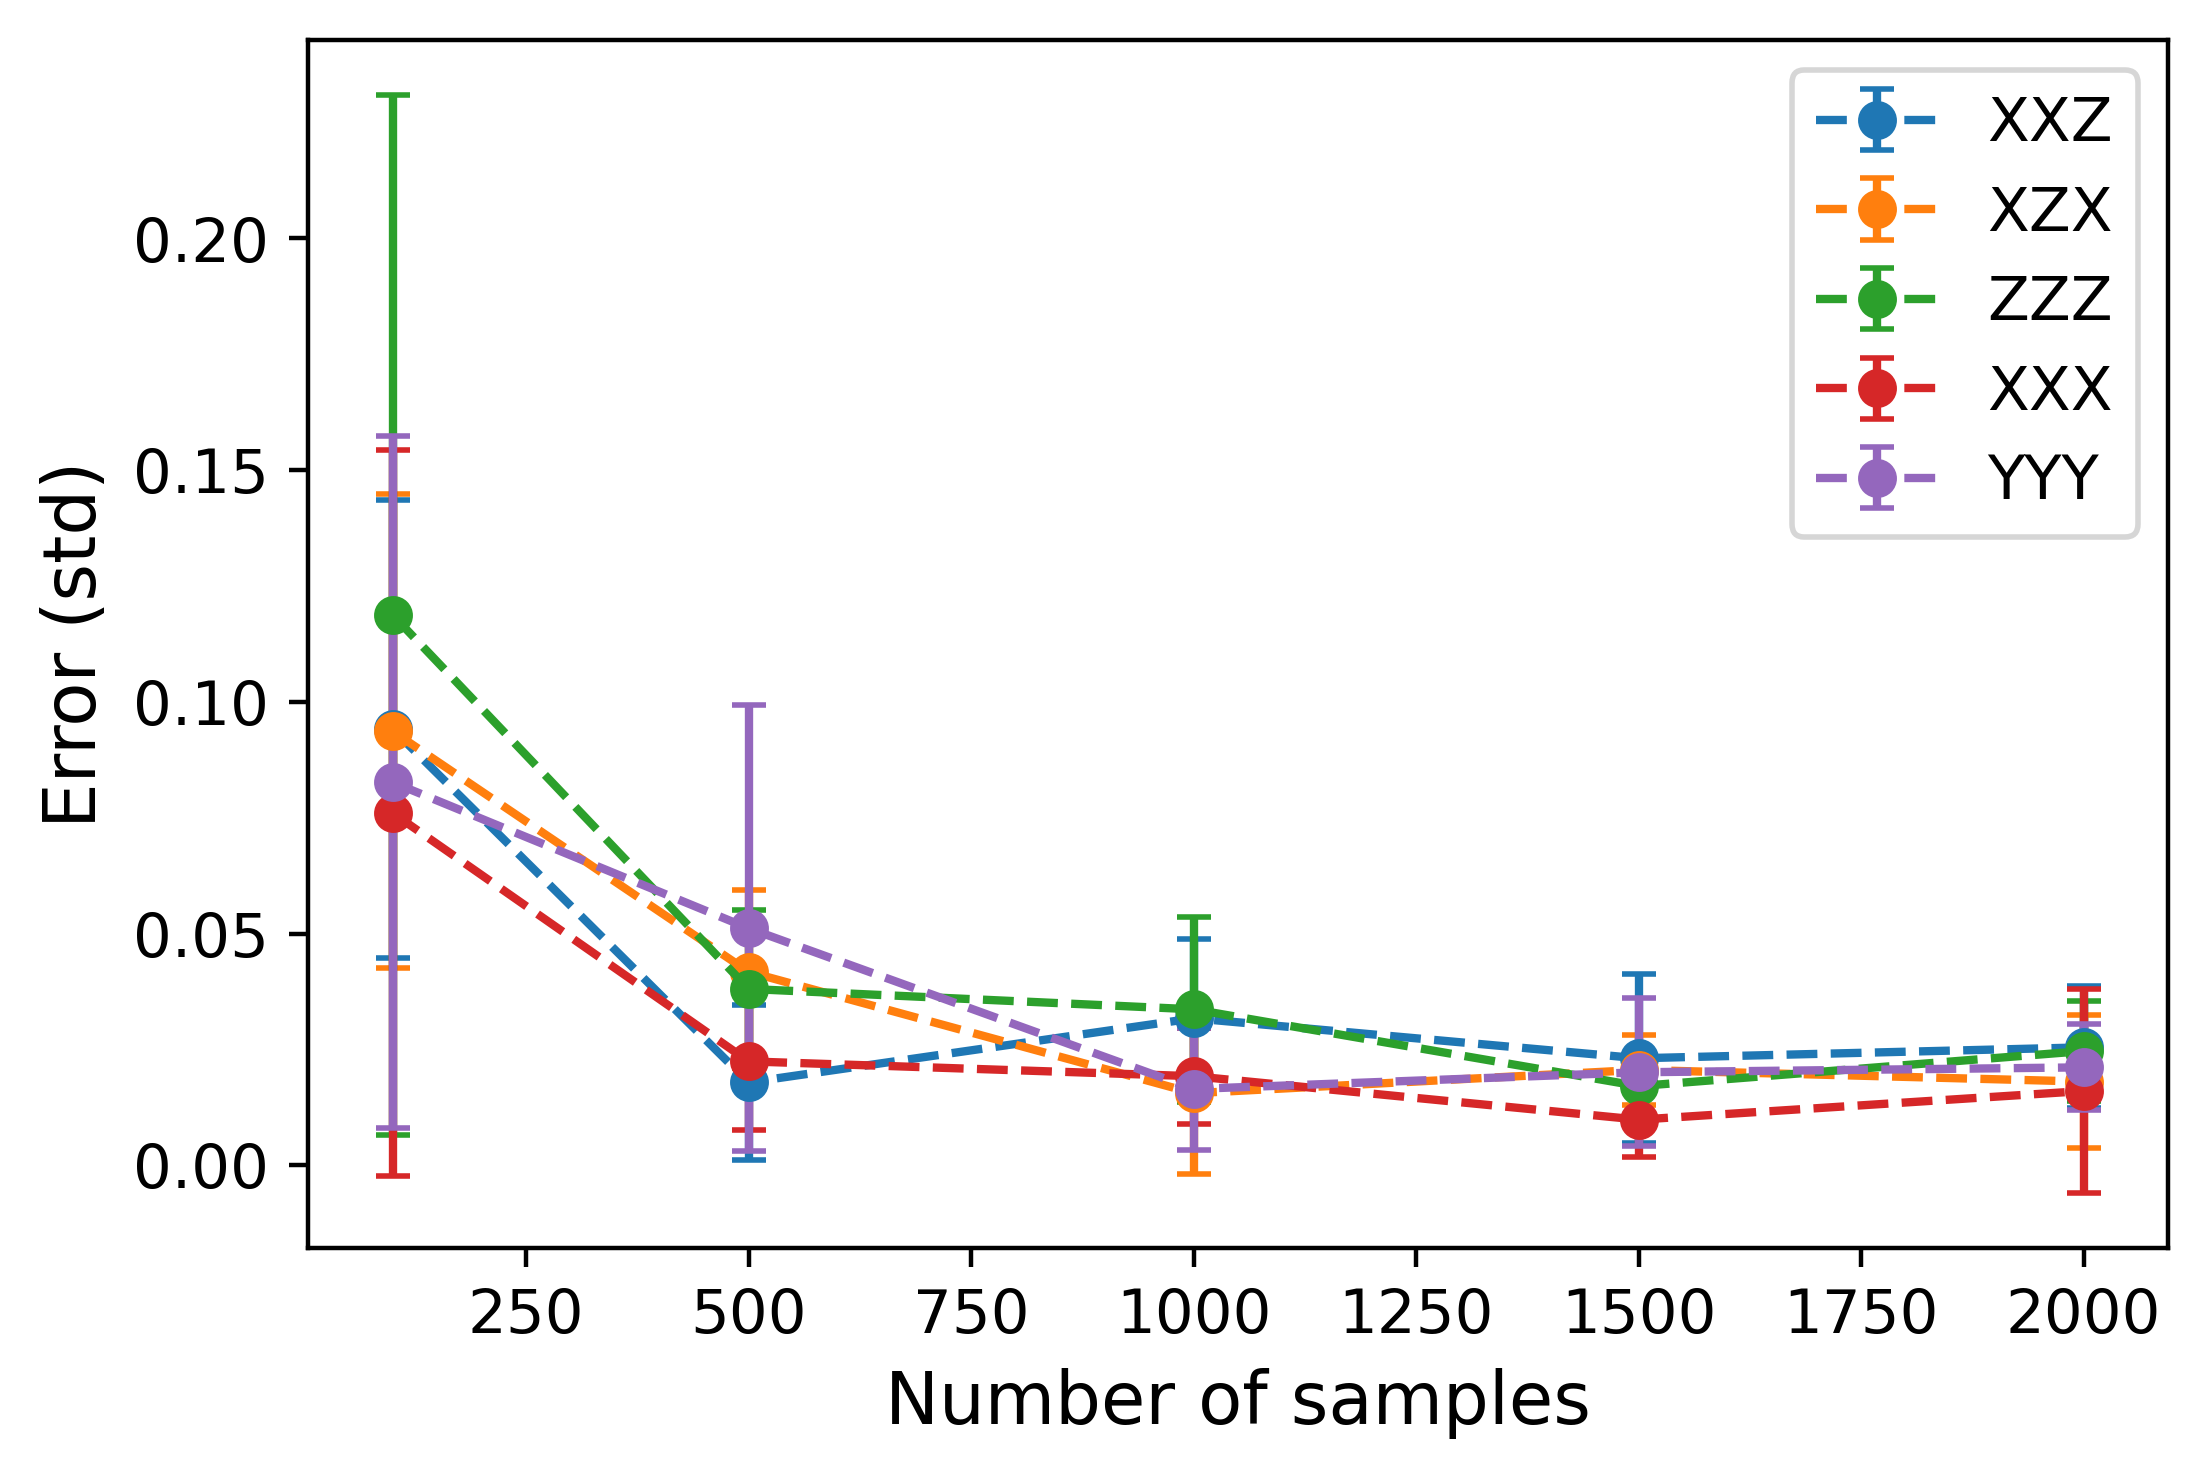

In [91]:
# navie estimation global observable by repetition
pauli_feature_observables = ['XXZ', 'XZX', 'ZZZ', 'XXX', 'YYY']
shadow_size_list = [100,500,1000,1500,2000]
state = rand_dm(N=8, dims=[[2, 2, 2], [2, 2, 2]])
for p_feature_ob in pauli_feature_observables:
    pob = tensor([pauli_ob[i] for i in p_feature_ob])
    y = []
    e = []
    for shadow_size in shadow_size_list:
        temp = []
        for repitition in range(5):
            eigenvalues, eigenstates, probabilities = measurement_statistics(state, pob)
            # print(eigenvalues,probabilities)
            # print('probabilities of two outcomes:',(1-np.inner(eigenvalues, probabilities))/2,(1+np.inner(eigenvalues, probabilities))/2)
            statistic_estimation=sum([ 1 if random.random() < (1+np.inner(eigenvalues, probabilities))/2 else -1 for i in range(shadow_size)])/shadow_size
            print(f'trace estimation: {expect(pob, state):.4f}, inner product: {np.inner(eigenvalues, probabilities):.4f}, statistic estimation: {statistic_estimation:.4f}')
            temp.append(abs(statistic_estimation-expect(pob, state)))
        y.append(np.mean(temp))
        e.append(np.std(temp))

    plt.errorbar(shadow_size_list, y, e, linestyle="dashed", marker="o",  capsize=3)
plt.xlabel('Number of samples')
plt.ylabel('Error (std)')
plt.legend(pauli_feature_observables)
plt.savefig('estimation_error.png', dpi=400,bbox_inches='tight')
plt.show()

In [120]:
measurement_file = 'measurement_3.txt'
observables_file = 'observables_3.txt'

with open(measurement_file) as f:
    measurements = f.readlines()
system_size = int(measurements[0])
print('measurements:',measurements)

full_measurement = []
for line in measurements[1:]:
    single_meaurement = []
    for pauli_XYZ, outcome in zip(line.split(" ")[0::2], line.split(" ")[1::2]):
        single_meaurement.append((pauli_XYZ, int(outcome)))
    full_measurement.append(single_meaurement)
print('full_measurement:',full_measurement)

# with open(sys.argv[3]) as f:
with open(observables_file) as f:
    content = f.readlines()
assert(system_size == int(content[0]))
print('observables:',content)

for line in content[1:]:
    one_observable = []
    for pauli_XYZ, position in zip(line.split(" ")[1::2], line.split(" ")[2::2]):
        one_observable.append((pauli_XYZ, int(position)))
    print(one_observable)
    sum_product, cnt_match = estimate_exp(full_measurement, one_observable)
    print(sum_product / cnt_match)

measurements: ['3\n', 'Z 1 X -1 X 1 \n', 'Y -1 Z -1 Z -1 \n', 'Y 1 X -1 X 1 \n', 'X 1 Y 1 X 1 \n', 'Z 1 Y 1 X 1 \n', 'X 1 X -1 Y -1 \n', 'Z 1 Z -1 Y 1 \n', 'Y 1 Y -1 X -1 \n', 'X -1 X 1 X 1 \n', 'Y -1 X -1 Y -1 \n', 'X -1 Y -1 X -1 \n', 'Z -1 Y -1 Y 1 \n', 'Y -1 X 1 X 1 \n', 'Y -1 Y 1 Z 1 \n', 'Y -1 Z -1 Z -1 \n', 'X 1 Z -1 Y -1 \n', 'Z 1 Z -1 Z 1 \n', 'Y -1 X 1 Y 1 \n', 'X -1 Y 1 Y 1 ']
full_measurement: [[('Z', 1), ('X', -1), ('X', 1)], [('Y', -1), ('Z', -1), ('Z', -1)], [('Y', 1), ('X', -1), ('X', 1)], [('X', 1), ('Y', 1), ('X', 1)], [('Z', 1), ('Y', 1), ('X', 1)], [('X', 1), ('X', -1), ('Y', -1)], [('Z', 1), ('Z', -1), ('Y', 1)], [('Y', 1), ('Y', -1), ('X', -1)], [('X', -1), ('X', 1), ('X', 1)], [('Y', -1), ('X', -1), ('Y', -1)], [('X', -1), ('Y', -1), ('X', -1)], [('Z', -1), ('Y', -1), ('Y', 1)], [('Y', -1), ('X', 1), ('X', 1)], [('Y', -1), ('Y', 1), ('Z', 1)], [('Y', -1), ('Z', -1), ('Z', -1)], [('X', 1), ('Z', -1), ('Y', -1)], [('Z', 1), ('Z', -1), ('Z', 1)], [('Y', -1), ('X', 1

In [2]:
# python data_acquisition_shadow.py -r 30 5
# python generate_observables.py
# python prediction_shadow.py -o measurement.txt observables.txt

## Versions of software package/module 

In [13]:
# about()
# conda list
# from qutip.ipynbtools import version_table
# version_table()
# qutip.cite()

print('numpy version:', np.__version__)
print('matplotlib version', mpl.__version__)

import sklearn
print('Scikit-learn version:', sklearn.__version__)
print('QuTiP version:', qutip.__version__)

numpy version: 1.21.5
matplotlib version 3.5.1
Scikit-learn version: 1.1.2
QuTiP version: 4.7.0
